In [318]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [320]:
import xgboost as xgb

In [322]:
# load data for hourly energy consumptions
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
# Cast as datetime
df.index = pd.to_datetime(df.index)
df = df.sort_values(by=['Datetime'])

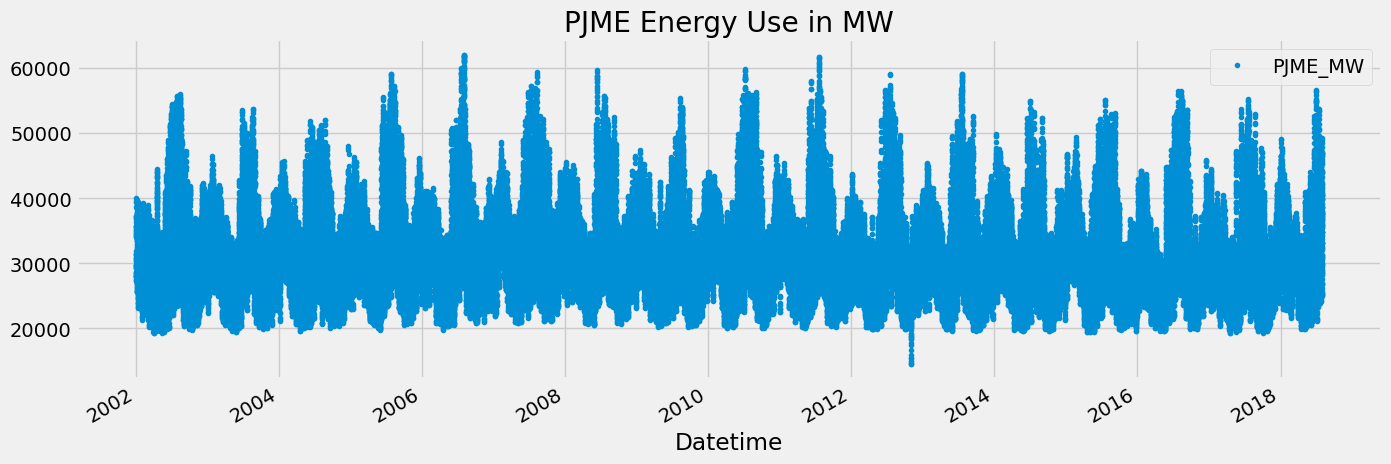

In [324]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

#Train/Test Split

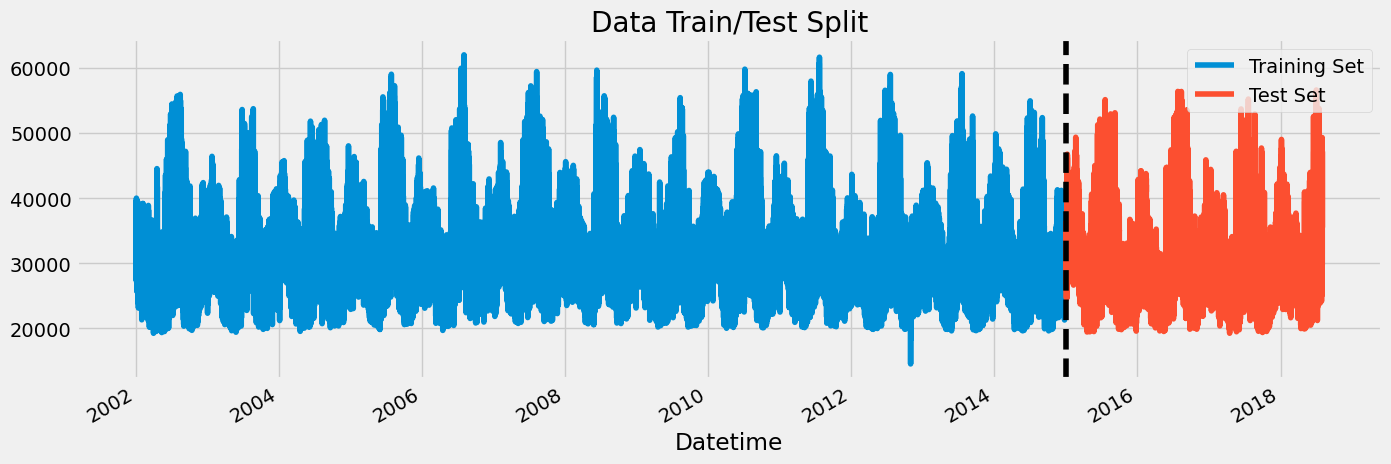

In [326]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

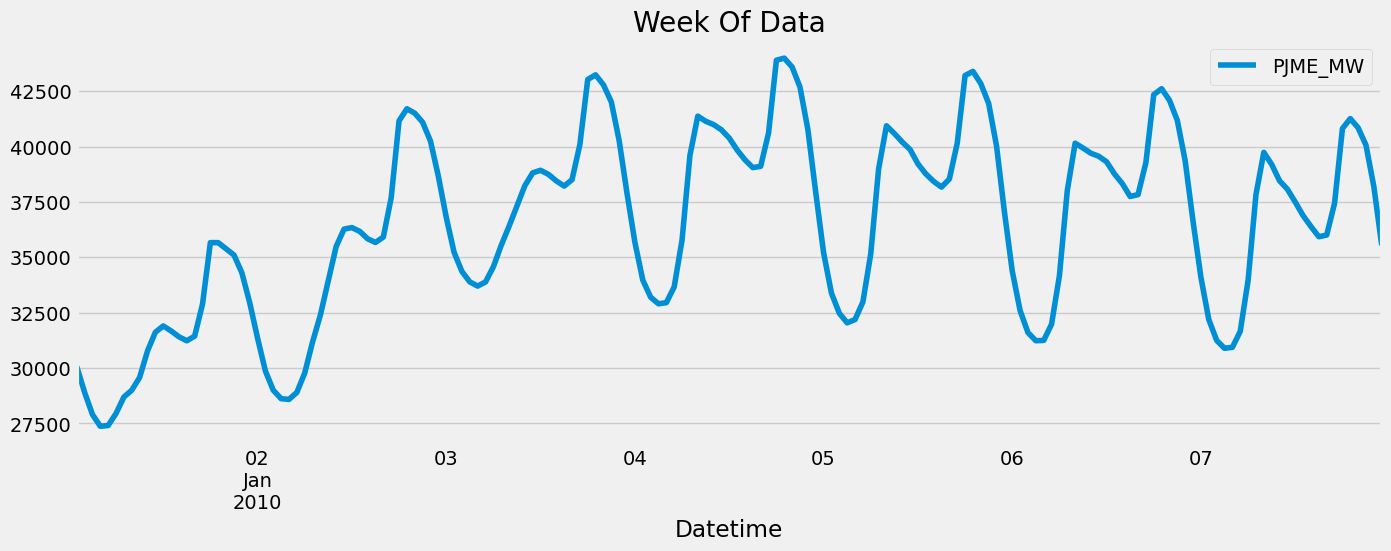

In [328]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

Feature Creation

In [372]:
def create_feature(df):
    """
    Create time series features based on the time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [374]:
df = create_feature(df)

Visualize our Feature/Target Relationship

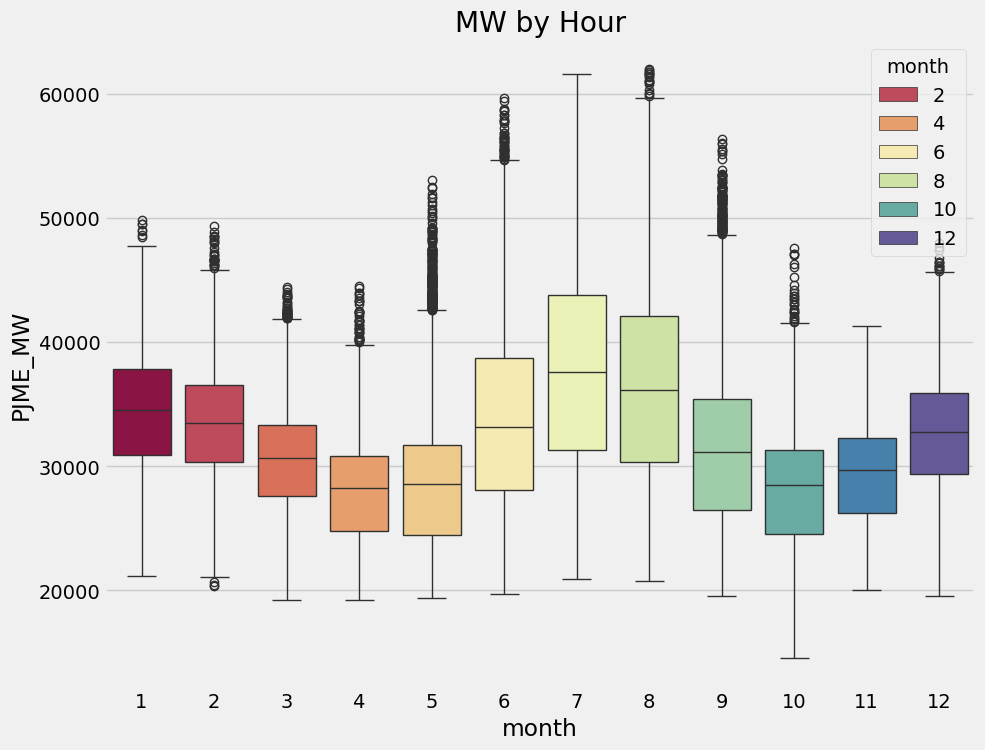

In [376]:
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x ='month', y='PJME_MW', hue = 'month', palette="Spectral")
ax.set_title('MW by Hour')
plt.show()

Create Model

In [378]:
# Create data set
train = create_feature(train)
test = create_feature(test)

features = ['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear']
target = 'PJME_MW'

In [380]:
# Train and test data set
X_train = train[features]
Y_train = train[target]
X_test = test[features]
Y_test = test[target]

In [382]:
# Train the model
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate = 0.01)
reg.fit(X_train,Y_train,\
    eval_set =[(X_train,Y_train),(X_test,Y_test)], \
    verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[416]	validation_0-rmse:2804.52217	validation_1-rmse:3748.41719


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Feature Importance

In [384]:
fi = pd.DataFrame(data=reg.feature_importances_, index =reg.feature_names_in_, columns=['importance'])

<Axes: title={'center': 'Feature Importance'}>

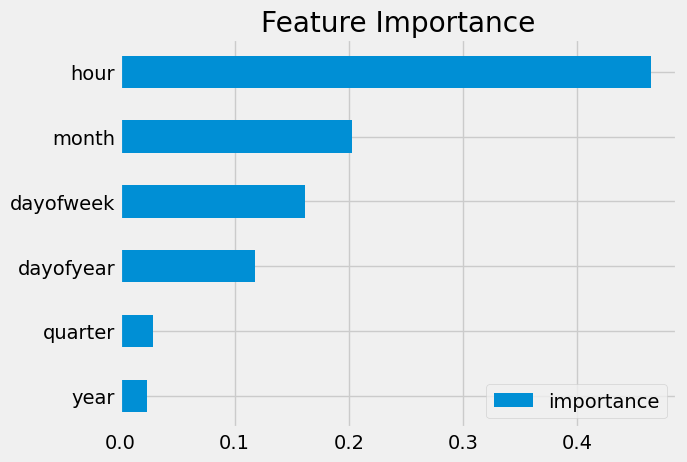

In [386]:
fi.sort_values('importance'). plot(kind='barh', title = 'Feature Importance')

Model used hour feature the most, then month, dayofweek, dayofyear.
Model used the quater and year the least

Forcast on Test

In [ ]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test['prediction'], how='left', left_index=True, right_index=True)

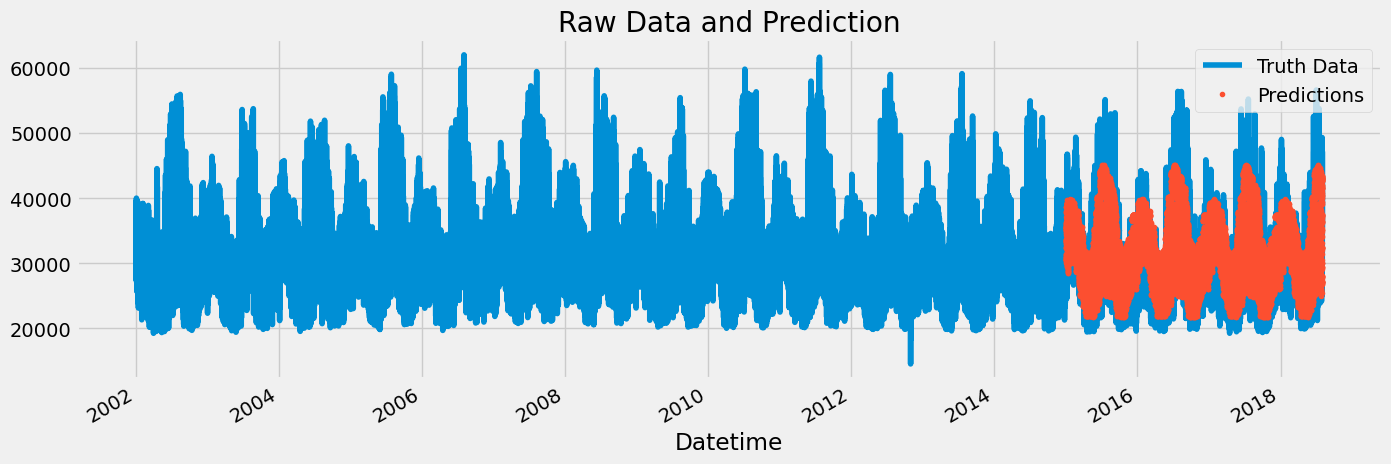

In [398]:
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

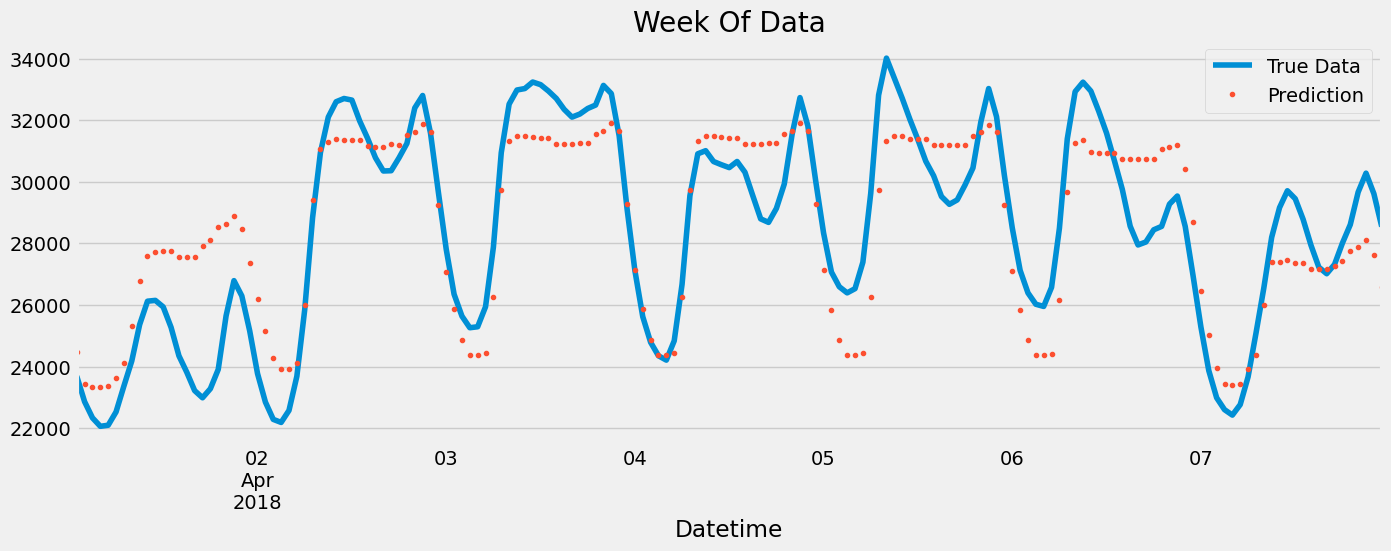

In [405]:
ax=df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW']\
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction']\
    .plot(style ='.')
plt.legend(['True Data', 'Prediction'])
plt.show()

Improve the model prediction by parameter tunning, add in features like specific days of the year (such as holidays)

In [410]:
#Run the evaluation matrix
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on tests set: {score:0.2f}')

RMSE Score on tests set: 3741.03


Calculate Error
- Look at the best and worst predicted days

In [442]:
test['error']= np.abs(test[target] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(5)


date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
Name: error, dtype: float64

In [ ]:
Next Steps
- More robust cross validation 
-add more features (weather forcast, holidays)